# Treniranje jezičkog modela

In [205]:
import flair.datasets
from flair.data import Sentence, Dictionary
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger, LanguageModel
from flair.trainers import ModelTrainer, LanguageModelTrainer, TextCorpus
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import collections
import glob
import pickle

### Generisanje rečnika

In [206]:
char_dictionary: Dictionary = Dictionary()
counter = collections.Counter()

In [207]:
files = glob.glob('corpus/**/*', recursive=True)
files.remove('corpus\\train')
print(files)

['corpus\\test.txt', 'corpus\\valid.txt', 'corpus\\train\\train_split_1', 'corpus\\train\\train_split_2']


In [208]:
# Number of processed lines
processed = 0

for file in files:

    with open(file, 'r', encoding='utf-8') as f:

        tokens = 0

        for line in f:
            processed += 1
            chars = list(line)
            tokens += len(chars)

            # Add chars to the dictionary
            counter.update(chars)


In [209]:
counter.keys()

dict_keys(['1', '9', '8', '4', 'K', 'a', 'o', ' ', 'i', 'b', 'č', 'n', ',', 'l', 'c', 'e', 'E', 'm', 'u', 'G', 'd', 'š', 't', 'j', 'N', 'r', 'g', 'p', '-', 's', 'k', '.', 'T', 'z', 'S', 'ž', 'h', 'đ', 'v', '(', ')', 'ć', 'P', 'V', 'B', 'D', 'O', ':', '–', 'f', '\n', '2', '0', 'I', 'M', 'A', 'U', 'L', 'Č', '’', '„', '!', '“', 'R', ';', 'J', 'Ž', 'Š', '3', 'Z', 'Ć', '5', '6', '7', '?', '/', 'H', '*', 'w', 'y', 'X', 'Y', 'ñ', '\xad', 'F', '=', 'â', 'C', '—', '[', ']', '_', "'", '^', '|', '&', '>', '<', '{', '}', '#', '+', '%', '”', '\\', '`', '~', 'Đ', '"'])

In [210]:
# Listing elements from most common to least common and summarizing their count
total_count = 0
for letter, count in counter.most_common():
    total_count += count

In [211]:
print("Total number of characters:",total_count)
print("Total number of processed lines:", processed)

Total number of characters: 67079
Total number of processed lines: 93


In [212]:
latin = set("abcčćddžđefghijklljmnnjoprsštuvzžABCČĆDDŽĐEFGHIJKLLJMNNJOPRSŠTUVZŽ")
numbers = set("0123456789")
punct = set(".?!,:;\"\'\/()[]{}_+-*^%#<>|&`~")

In [213]:
latin.issubset(set(counter.keys()))

True

In [214]:
numbers.issubset(set(counter.keys()))

True

In [215]:
punct.issubset(set(counter.keys()))

True

In [216]:
summ = 0
idx = 0
for letter, count in counter.most_common():
    summ += count
    percentile = (summ / total_count)

    char_dictionary.add_item(letter)
    idx += 1
    print('%d\t%s\t%7d\t%7d\t%f' % (idx, letter, count, summ, percentile))

1	 	  11740	  11740	0.175018
2	a	   5880	  17620	0.262675
3	o	   5229	  22849	0.340628
4	e	   4862	  27711	0.413110
5	i	   4649	  32360	0.482416
6	n	   3353	  35713	0.532402
7	r	   2515	  38228	0.569895
8	t	   2454	  40682	0.606479
9	s	   2400	  43082	0.642258
10	j	   2223	  45305	0.675398
11	u	   2144	  47449	0.707360
12	d	   1967	  49416	0.736684
13	l	   1810	  51226	0.763667
14	m	   1774	  53000	0.790113
15	k	   1762	  54762	0.816381
16	v	   1736	  56498	0.842261
17	p	   1390	  57888	0.862982
18	g	    940	  58828	0.876996
19	,	    831	  59659	0.889384
20	b	    793	  60452	0.901206
21	z	    786	  61238	0.912924
22	.	    603	  61841	0.921913
23	č	    509	  62350	0.929501
24	š	    480	  62830	0.936657
25	c	    364	  63194	0.942083
26	ž	    302	  63496	0.946585
27	h	    272	  63768	0.950640
28	ć	    244	  64012	0.954278
29	-	    133	  64145	0.956261
30	1	    122	  64267	0.958079
31	S	    122	  64389	0.959898
32	f	    118	  64507	0.961657
33	A	    108	  64615	0.963267
34	đ	    101	  6471

In [217]:
with open('resources/char_mappings/latin_dict', 'wb') as f:
    mappings = {
        'idx2item': char_dictionary.idx2item,
        'item2idx': char_dictionary.item2idx
    }
    pickle.dump(mappings, f)

### Traniranje embedding-a

In [218]:
is_forward_lm = True
dictionary: Dictionary = Dictionary.load_from_file('resources/char_mappings/latin_dict')

# get your corpus, process forward and at the character level
corpus = TextCorpus('corpus',
                    dictionary,
                    is_forward_lm,
                    character_level=True)

# instantiate your language model, set hidden size and number of layers
# U pozadini LanguageModel-a je rekurzivna neuronska mreza iz PyTorch bibloteke, konkretno LSTM ili GRU
language_model = LanguageModel(dictionary,
                               is_forward_lm,
                               hidden_size=128,
                               nlayers=1)
trainer = LanguageModelTrainer(language_model, corpus)

trainer.train('resources/taggers/language_model',
              sequence_length=40,
              mini_batch_size=20,
              max_epochs=20)

2022-08-28 23:40:21,044 read text file with 8 lines
2022-08-28 23:40:21,054 read text file with 8 lines
2022-08-28 23:40:25,649 Sequence length is 40
2022-08-28 23:40:25,651 Split 1	 - (23:40:25)
2022-08-28 23:40:27,148 best split so far
2022-08-28 23:40:27,150 best loss so far 3.43116272
2022-08-28 23:40:27,659 ('\nlpuo,orrooñeonesisepeoeiŽutvčuoleresemaezknooakenodomuvemeiooduZut4anu7igeAagahpika,gkegoijaopgaoroojoediokenoosenapos-oogo)aiooopri iijipasnonaiosurirroodogoogolOoraoi<unk>oosoeveoutietosavopneugiopiPieov}uosoojooaomautaoteoo.toslovi(Sdoriosomomonolekka9Oo,adsodoohauaZoaeeoneonomosoideoftodvotigo7e)a?ouiulijjosibBisao~olaro.Ziloleamssaopgčle–ooljan}adoi\' vuolapoporitorre,čroavoniuos oke"ioj\njjogivolDap[i_neenpuvoš.đooooukoo\nookaololreiolre žozbeeujolkoonjeokoo{našlokalaide&pedaos,l,jngotoopoeinakejteĐoojočiosomeu,elavimočimtĐro7tjaovebanasojealo4lzr–oĐikeidosabzečionooŠokopaimšpemiokomo0lodoamoudolnovoevaooabooodŽo>att kgazočAšosobncšavojKoub,do\\ađuodjosonsleladopsokoe

In [223]:
sentence = Sentence('Ja volim Beograd.')

# init embeddings from your trained LM
char_lm_embeddings = FlairEmbeddings('resources/taggers/language_model/best-lm.pt')

# embed sentence
char_lm_embeddings.embed(sentence)
print(sentence.get_embedding())

tensor([])


In [224]:
corpus_1 = flair.datasets.UD_SERBIAN().downsample(0.1)

2022-08-28 23:52:43,953 Reading data from C:\Users\Goran\.flair\datasets\ud_serbian
2022-08-28 23:52:43,953 Train: C:\Users\Goran\.flair\datasets\ud_serbian\sr_set-ud-train.conllu
2022-08-28 23:52:43,955 Dev: C:\Users\Goran\.flair\datasets\ud_serbian\sr_set-ud-dev.conllu
2022-08-28 23:52:43,955 Test: C:\Users\Goran\.flair\datasets\ud_serbian\sr_set-ud-test.conllu


In [225]:
label_type = 'upos'
label_dict  = corpus_1.make_label_dictionary(label_type = label_type)

2022-08-28 23:53:02,838 Computing label dictionary. Progress:


333it [00:00, 11101.78it/s]

2022-08-28 23:53:02,874 Dictionary created for label 'upos' with 16 values: NOUN (seen 1732 times), PUNCT (seen 965 times), ADJ (seen 847 times), ADP (seen 701 times), PROPN (seen 604 times), VERB (seen 601 times), AUX (seen 454 times), DET (seen 268 times), SCONJ (seen 254 times), CCONJ (seen 248 times), ADV (seen 234 times), PRON (seen 148 times), NUM (seen 115 times), PART (seen 45 times), X (seen 12 times)


In [229]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('resources/taggers/language_model/best-lm.pt')
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

2022-08-28 23:55:06,766 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to C:\Users\Goran\AppData\Local\Temp\tmpsr1ew7vz


100%|██████████| 160000128/160000128 [02:36<00:00, 1022033.01B/s]

2022-08-28 23:57:43,518 copying C:\Users\Goran\AppData\Local\Temp\tmpsr1ew7vz to cache at C:\Users\Goran\.flair\embeddings\glove.gensim.vectors.npy


2022-08-28 23:57:43,677 removing temp file C:\Users\Goran\AppData\Local\Temp\tmpsr1ew7vz
2022-08-28 23:57:44,059 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to C:\Users\Goran\AppData\Local\Temp\tmpa0ai0b2z


100%|██████████| 21494764/21494764 [00:21<00:00, 1014645.02B/s]

2022-08-28 23:58:05,508 copying C:\Users\Goran\AppData\Local\Temp\tmpa0ai0b2z to cache at C:\Users\Goran\.flair\embeddings\glove.gensim
2022-08-28 23:58:05,553 removing temp file C:\Users\Goran\AppData\Local\Temp\tmpa0ai0b2z


In [230]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type='upos',
                        use_crf=True)

trainer = ModelTrainer(tagger, corpus_1)

2022-08-28 23:58:48,335 SequenceTagger predicts: Dictionary with 18 tags: <unk>, NOUN, PUNCT, ADJ, ADP, PROPN, VERB, AUX, DET, SCONJ, CCONJ, ADV, PRON, NUM, PART, X, <START>, <STOP>


In [231]:
trainer.train('resources/taggers/language_model_testing',
              learning_rate=0.1,
              mini_batch_size=500,
              max_epochs=20)

2022-08-29 00:00:57,485 ----------------------------------------------------------------------------------------------------
2022-08-29 00:00:57,487 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.1, inplace=False)
        (encoder): Embedding(110, 100)
        (rnn): LSTM(100, 128)
        (decoder): Linear(in_features=128, out_features=110, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=228, out_features=228, bias=True)
  (rnn): LSTM(228, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=18, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)"
2022-08-29 00:00:57,489 ------------------------------------------------------------------

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

2022-08-29 00:01:07,269 Evaluating as a multi-label problem: False
2022-08-29 00:01:07,299 DEV : loss 3.015528440475464 - f1-score (micro avg)  0.0471
2022-08-29 00:01:07,311 BAD EPOCHS (no improvement): 0
2022-08-29 00:01:07,313 saving best model


2022-08-29 00:01:09,421 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:16,115 epoch 2 - iter 1/1 - loss 3.04089889 - samples/sec: 74.72 - lr: 0.100000
2022-08-29 00:01:16,117 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:16,119 EPOCH 2 done: loss 3.0409 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

2022-08-29 00:01:16,565 Evaluating as a multi-label problem: False
2022-08-29 00:01:16,593 DEV : loss 2.838514804840088 - f1-score (micro avg)  0.099
2022-08-29 00:01:16,605 BAD EPOCHS (no improvement): 0
2022-08-29 00:01:16,607 saving best model


2022-08-29 00:01:19,068 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:26,940 epoch 3 - iter 1/1 - loss 2.86286566 - samples/sec: 63.61 - lr: 0.100000
2022-08-29 00:01:26,940 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:26,942 EPOCH 3 done: loss 2.8629 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

2022-08-29 00:01:27,473 Evaluating as a multi-label problem: False
2022-08-29 00:01:27,501 DEV : loss 2.6780385971069336 - f1-score (micro avg)  0.1357
2022-08-29 00:01:27,513 BAD EPOCHS (no improvement): 0
2022-08-29 00:01:27,517 saving best model


2022-08-29 00:01:29,223 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:36,205 epoch 4 - iter 1/1 - loss 2.70077195 - samples/sec: 71.64 - lr: 0.100000
2022-08-29 00:01:36,205 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:36,209 EPOCH 4 done: loss 2.7008 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

2022-08-29 00:01:36,702 Evaluating as a multi-label problem: False
2022-08-29 00:01:36,730 DEV : loss 2.5440409183502197 - f1-score (micro avg)  0.2163
2022-08-29 00:01:36,742 BAD EPOCHS (no improvement): 0
2022-08-29 00:01:36,744 saving best model


2022-08-29 00:01:38,830 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:46,551 epoch 5 - iter 1/1 - loss 2.56787731 - samples/sec: 64.79 - lr: 0.100000
2022-08-29 00:01:46,553 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:46,553 EPOCH 5 done: loss 2.5679 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

2022-08-29 00:01:46,965 Evaluating as a multi-label problem: False
2022-08-29 00:01:46,991 DEV : loss 2.4232189655303955 - f1-score (micro avg)  0.261
2022-08-29 00:01:47,005 BAD EPOCHS (no improvement): 0
2022-08-29 00:01:47,007 saving best model


2022-08-29 00:01:48,812 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:55,758 epoch 6 - iter 1/1 - loss 2.44337667 - samples/sec: 72.02 - lr: 0.100000
2022-08-29 00:01:55,760 ----------------------------------------------------------------------------------------------------
2022-08-29 00:01:55,762 EPOCH 6 done: loss 2.4434 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

2022-08-29 00:01:56,290 Evaluating as a multi-label problem: False
2022-08-29 00:01:56,330 DEV : loss 2.2984402179718018 - f1-score (micro avg)  0.261
2022-08-29 00:01:56,342 BAD EPOCHS (no improvement): 0
2022-08-29 00:01:56,346 ----------------------------------------------------------------------------------------------------


2022-08-29 00:02:03,648 epoch 7 - iter 1/1 - loss 2.33368065 - samples/sec: 68.52 - lr: 0.100000
2022-08-29 00:02:03,650 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:03,650 EPOCH 7 done: loss 2.3337 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

2022-08-29 00:02:04,108 Evaluating as a multi-label problem: False
2022-08-29 00:02:04,136 DEV : loss 2.1844942569732666 - f1-score (micro avg)  0.3208
2022-08-29 00:02:04,150 BAD EPOCHS (no improvement): 0
2022-08-29 00:02:04,152 saving best model


2022-08-29 00:02:06,104 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:13,404 epoch 8 - iter 1/1 - loss 2.21966347 - samples/sec: 68.53 - lr: 0.100000
2022-08-29 00:02:13,406 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:13,408 EPOCH 8 done: loss 2.2197 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

2022-08-29 00:02:13,907 Evaluating as a multi-label problem: False
2022-08-29 00:02:13,937 DEV : loss 2.0743792057037354 - f1-score (micro avg)  0.3472
2022-08-29 00:02:13,949 BAD EPOCHS (no improvement): 0
2022-08-29 00:02:13,956 saving best model


2022-08-29 00:02:15,638 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:22,939 epoch 9 - iter 1/1 - loss 2.12516037 - samples/sec: 68.50 - lr: 0.100000
2022-08-29 00:02:22,939 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:22,941 EPOCH 9 done: loss 2.1252 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

2022-08-29 00:02:23,388 Evaluating as a multi-label problem: False
2022-08-29 00:02:23,413 DEV : loss 1.9880850315093994 - f1-score (micro avg)  0.3751
2022-08-29 00:02:23,425 BAD EPOCHS (no improvement): 0
2022-08-29 00:02:23,427 saving best model


2022-08-29 00:02:25,240 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:32,591 epoch 10 - iter 1/1 - loss 2.03935015 - samples/sec: 68.05 - lr: 0.100000
2022-08-29 00:02:32,591 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:32,593 EPOCH 10 done: loss 2.0394 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

2022-08-29 00:02:33,087 Evaluating as a multi-label problem: False
2022-08-29 00:02:33,115 DEV : loss 1.907584547996521 - f1-score (micro avg)  0.4166
2022-08-29 00:02:33,127 BAD EPOCHS (no improvement): 0
2022-08-29 00:02:33,129 saving best model


2022-08-29 00:02:34,963 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:42,137 epoch 11 - iter 1/1 - loss 1.97621811 - samples/sec: 69.74 - lr: 0.100000
2022-08-29 00:02:42,139 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:42,141 EPOCH 11 done: loss 1.9762 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

2022-08-29 00:02:42,685 Evaluating as a multi-label problem: False
2022-08-29 00:02:42,714 DEV : loss 1.8681714534759521 - f1-score (micro avg)  0.4238
2022-08-29 00:02:42,728 BAD EPOCHS (no improvement): 0
2022-08-29 00:02:42,730 saving best model


2022-08-29 00:02:44,622 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:51,828 epoch 12 - iter 1/1 - loss 1.92248231 - samples/sec: 69.43 - lr: 0.100000
2022-08-29 00:02:51,830 ----------------------------------------------------------------------------------------------------
2022-08-29 00:02:51,830 EPOCH 12 done: loss 1.9225 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

2022-08-29 00:02:52,316 Evaluating as a multi-label problem: False
2022-08-29 00:02:52,338 DEV : loss 1.7876362800598145 - f1-score (micro avg)  0.4517
2022-08-29 00:02:52,350 BAD EPOCHS (no improvement): 0
2022-08-29 00:02:52,352 saving best model


2022-08-29 00:02:54,343 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:02,725 epoch 13 - iter 1/1 - loss 1.87893003 - samples/sec: 59.69 - lr: 0.100000
2022-08-29 00:03:02,726 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:02,728 EPOCH 13 done: loss 1.8789 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

2022-08-29 00:03:03,227 Evaluating as a multi-label problem: False
2022-08-29 00:03:03,259 DEV : loss 1.767737865447998 - f1-score (micro avg)  0.4453
2022-08-29 00:03:03,271 BAD EPOCHS (no improvement): 1
2022-08-29 00:03:03,273 ----------------------------------------------------------------------------------------------------


2022-08-29 00:03:10,843 epoch 14 - iter 1/1 - loss 1.84136007 - samples/sec: 66.09 - lr: 0.100000
2022-08-29 00:03:10,847 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:10,847 EPOCH 14 done: loss 1.8414 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

2022-08-29 00:03:11,287 Evaluating as a multi-label problem: False
2022-08-29 00:03:11,313 DEV : loss 1.6910561323165894 - f1-score (micro avg)  0.4669
2022-08-29 00:03:11,323 BAD EPOCHS (no improvement): 0
2022-08-29 00:03:11,326 saving best model


2022-08-29 00:03:13,075 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:20,777 epoch 15 - iter 1/1 - loss 1.77312972 - samples/sec: 64.97 - lr: 0.100000
2022-08-29 00:03:20,779 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:20,781 EPOCH 15 done: loss 1.7731 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

2022-08-29 00:03:21,251 Evaluating as a multi-label problem: False
2022-08-29 00:03:21,277 DEV : loss 1.6712538003921509 - f1-score (micro avg)  0.4677
2022-08-29 00:03:21,289 BAD EPOCHS (no improvement): 0
2022-08-29 00:03:21,291 saving best model


2022-08-29 00:03:22,960 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:30,012 epoch 16 - iter 1/1 - loss 1.74297680 - samples/sec: 70.95 - lr: 0.100000
2022-08-29 00:03:30,016 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:30,018 EPOCH 16 done: loss 1.7430 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

2022-08-29 00:03:30,576 Evaluating as a multi-label problem: False
2022-08-29 00:03:30,602 DEV : loss 1.6045674085617065 - f1-score (micro avg)  0.4868
2022-08-29 00:03:30,616 BAD EPOCHS (no improvement): 0
2022-08-29 00:03:30,618 saving best model


2022-08-29 00:03:32,813 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:39,917 epoch 17 - iter 1/1 - loss 1.70963181 - samples/sec: 70.42 - lr: 0.100000
2022-08-29 00:03:39,919 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:39,921 EPOCH 17 done: loss 1.7096 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

2022-08-29 00:03:40,377 Evaluating as a multi-label problem: False
2022-08-29 00:03:40,405 DEV : loss 1.5909781455993652 - f1-score (micro avg)  0.4868
2022-08-29 00:03:40,417 BAD EPOCHS (no improvement): 0
2022-08-29 00:03:40,419 ----------------------------------------------------------------------------------------------------


2022-08-29 00:03:47,700 epoch 18 - iter 1/1 - loss 1.68015984 - samples/sec: 68.72 - lr: 0.100000
2022-08-29 00:03:47,702 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:47,704 EPOCH 18 done: loss 1.6802 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

2022-08-29 00:03:48,209 Evaluating as a multi-label problem: False
2022-08-29 00:03:48,243 DEV : loss 1.5299181938171387 - f1-score (micro avg)  0.502
2022-08-29 00:03:48,257 BAD EPOCHS (no improvement): 0
2022-08-29 00:03:48,259 saving best model


2022-08-29 00:03:50,136 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:57,280 epoch 19 - iter 1/1 - loss 1.62883329 - samples/sec: 70.01 - lr: 0.100000
2022-08-29 00:03:57,282 ----------------------------------------------------------------------------------------------------
2022-08-29 00:03:57,282 EPOCH 19 done: loss 1.6288 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

2022-08-29 00:03:57,773 Evaluating as a multi-label problem: False
2022-08-29 00:03:57,803 DEV : loss 1.5154139995574951 - f1-score (micro avg)  0.5172
2022-08-29 00:03:57,813 BAD EPOCHS (no improvement): 0
2022-08-29 00:03:57,815 saving best model


2022-08-29 00:03:59,554 ----------------------------------------------------------------------------------------------------
2022-08-29 00:04:06,970 epoch 20 - iter 1/1 - loss 1.60253771 - samples/sec: 67.44 - lr: 0.100000
2022-08-29 00:04:06,972 ----------------------------------------------------------------------------------------------------
2022-08-29 00:04:06,972 EPOCH 20 done: loss 1.6025 - lr 0.100000


100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

2022-08-29 00:04:07,485 Evaluating as a multi-label problem: False
2022-08-29 00:04:07,513 DEV : loss 1.462044358253479 - f1-score (micro avg)  0.5148
2022-08-29 00:04:07,525 BAD EPOCHS (no improvement): 1


2022-08-29 00:04:09,271 ----------------------------------------------------------------------------------------------------
2022-08-29 00:04:09,273 loading file resources\taggers\language_model_testing\best-model.pt
2022-08-29 00:04:09,757 SequenceTagger predicts: Dictionary with 18 tags: <unk>, NOUN, PUNCT, ADJ, ADP, PROPN, VERB, AUX, DET, SCONJ, CCONJ, ADV, PRON, NUM, PART, X, <START>, <STOP>


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

2022-08-29 00:04:10,725 Evaluating as a multi-label problem: False
2022-08-29 00:04:10,751 0.502	0.502	0.502	0.502
2022-08-29 00:04:10,753 
Results:
- F-score (micro) 0.502
- F-score (macro) 0.2947
- Accuracy 0.502

By class:
              precision    recall  f1-score   support

        NOUN     0.5305    0.5541    0.5421       314
       PUNCT     0.8270    0.9871    0.9000       155
         ADJ     0.3316    0.4741    0.3902       135
         ADP     0.7667    0.8042    0.7850       143
        VERB     0.2787    0.3009    0.2894       113
         AUX     0.3577    0.6901    0.4712        71
       PROPN     0.1746    0.1048    0.1310       105
       SCONJ     0.4737    0.2045    0.2857        44
         DET     0.0000    0.0000    0.0000        39
         ADV     0.1429    0.0222    0.0385        45
       CCONJ     0.8333    0.4545    0.5882        33
        PRON     0.0000    0.0000    0.0000        28
         NUM     0.0000    0.0000    0.0000        11
        PART     

{'test_score': 0.5020080321285141,
 'dev_score_history': [0.047086991221069435,
  0.09896249002394254,
  0.13567438148443736,
  0.2162809257781325,
  0.26097366320830007,
  0.26097366320830007,
  0.320830007980846,
  0.34716679968076614,
  0.3750997605746209,
  0.4166001596169194,
  0.4237829209896249,
  0.45171588188347966,
  0.44533120510774143,
  0.4668794892258579,
  0.4676775738228252,
  0.4868316041500399,
  0.4868316041500399,
  0.5019952114924182,
  0.5171588188347965,
  0.5147645650438947],
 'train_loss_history': [3.235918476757056,
  3.040898891463752,
  2.8628656569936357,
  2.700771954551743,
  2.567877308729939,
  2.443376668857222,
  2.33368065163254,
  2.2196634669427917,
  2.125160373504081,
  2.039350145484574,
  1.9762181090464168,
  1.9224823116266603,
  1.8789300290536801,
  1.841360069996887,
  1.7731297233847538,
  1.742976802452269,
  1.7096318137797455,
  1.6801598384753735,
  1.6288332915398451,
  1.6025377114174046],
 'dev_loss_history': [3.015528440475464,
  

In [232]:
# load the model you trained
model = SequenceTagger.load('resources/taggers/language_model_testing/final-model.pt')

2022-08-29 00:05:44,409 loading file resources/taggers/language_model_testing/final-model.pt
2022-08-29 00:05:45,063 SequenceTagger predicts: Dictionary with 18 tags: <unk>, NOUN, PUNCT, ADJ, ADP, PROPN, VERB, AUX, DET, SCONJ, CCONJ, ADV, PRON, NUM, PART, X, <START>, <STOP>


In [233]:


# create example sentence
# TODO: Matrica konfuzije za predikciju,
actualSentenceExample = corpus_1.dev[17]
predictedSentenceExample = Sentence(actualSentenceExample.to_plain_string())
model.predict(predictedSentenceExample)
print("\n\n")
# predict tags and print

for i,token in enumerate(predictedSentenceExample):
    predictedLabels = token.get_labels('upos')
    actualLabels = actualSentenceExample[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




" - predicted: PUNCT , actual: PUNCT
Trenutno - predicted: VERB , actual: ADV
se - predicted: ADP , actual: PRON
teretni - predicted: NOUN , actual: ADJ
transport - predicted: ADJ , actual: NOUN
odvija - predicted: ADJ , actual: VERB
isključivo - predicted: NOUN , actual: ADV
velikim - predicted: ADJ , actual: ADJ
kamionima - predicted: NOUN , actual: NOUN
. - predicted: PUNCT , actual: PUNCT


In [235]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus_1.dev:
    predictedSentence = Sentence(actualSentence.to_plain_string())
    model.predict(predictedSentence)


    numTokens = min(len(predictedSentence.tokens),len(actualSentence.tokens))
    i=0
    punctCount = 0

    while i+punctCount<numTokens:
        actualLabels = actualSentence[i].get_labels('upos')

        if predictedSentence[i+punctCount].labels[0].data_point.form == ".":
            punctCount+=1

        if i+punctCount >= numTokens:
            break
        predictedLabels = predictedSentence[i+punctCount].get_labels('upos')

        numLabels = min(len(actualLabels),len(predictedLabels))
        j=0
        while j<numLabels:
            predicted = np.append(predicted, predictedLabels[j].value)
            actual = np.append(actual, actualLabels[j].value)
            j+=1
        i+=1


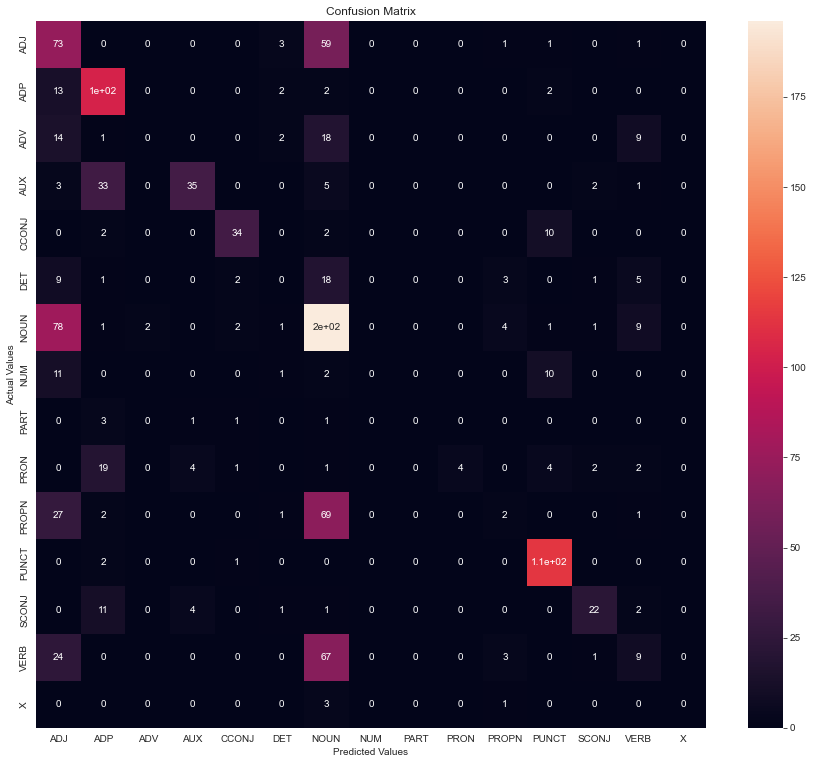

In [236]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [237]:
sentence = Sentence('Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti.')

# predict tags and print
model.predict(sentence)

print(sentence.to_tagged_string())

Sentence: "Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti ." → ["Srbija"/VERB, "je"/ADP, "tokom"/NOUN, "bombardovanja"/ADJ, "devedesetih"/NOUN, "izgubila"/ADJ, "mnoge"/NOUN, "kulturne"/ADJ, "znamenitosti"/NOUN, "."/PUNCT]


In [238]:
char_lm_embeddings.embed(sentence)

[Sentence: "Srbija je tokom bombardovanja devedesetih izgubila mnoge kulturne znamenitosti ." → ["Srbija"/VERB, "je"/ADP, "tokom"/NOUN, "bombardovanja"/ADJ, "devedesetih"/NOUN, "izgubila"/ADJ, "mnoge"/NOUN, "kulturne"/ADJ, "znamenitosti"/NOUN, "."/PUNCT]]

In [240]:
print(sentence.get_embedding())

tensor([])
